In [1]:
import pandas as pd
df=pd.read_csv('/content/all_stocks_5yr.csv')
df.head()

FileNotFoundError: ignored

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
df.tail()

,date,open,high,low,close,volume,Name
372855,2014-03-26,54.57,54.80,53.4500,53.58,7311023,MET
372856,2014-03-27,53.37,53.44,52.1600,52.36,5926490,MET
372857,2014-03-28,52.50,52.95,52.1001,52.56,4738906,MET
372858,2014-03-31,52.93,53.31,52.6600,52.80,5258744,MET
372859,2014-04-01,54.43,54.43,53.2100,53.44,59328,NaN


In [ ]:
df1=df.reset_index()['close']
df1

0         14.75
1         14.46
2         14.27
3         14.66
4         13.99
          ...  
372855    53.58
372856    52.36
372857    52.56
372858    52.80
372859    53.44
Name: close, Length: 372860, dtype: float64

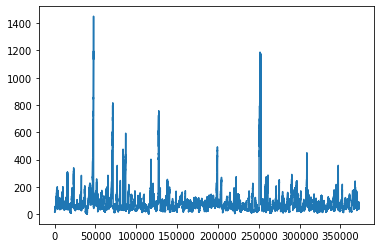

In [ ]:
import matplotlib.pyplot as plt
plt.plot(df1)

In [ ]:
### LSTM are sensitive to the scale of the data. so we apply MinMax scaler 
import numpy as np
df1

0         14.75
1         14.46
2         14.27
3         14.66
4         13.99
          ...  
372855    53.58
372856    52.36
372857    52.56
372858    52.80
372859    53.44
Name: close, Length: 372860, dtype: float64

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))
print(df1)

[[0.00908025]
 [0.00888015]
 [0.00874905]
 ...
 [0.0351687 ]
 [0.0353343 ]
 [0.03577589]]


In [ ]:
##splitting dataset into train and test split
training_size=int(len(df1)*0.65)
test_size=len(df1)-training_size
train_data,test_data=df1[0:training_size,:],df1[training_size:len(df1),:1]
training_size,test_size

(242359, 130501)

In [ ]:
train_data

array([[0.00908025],
       [0.00888015],
       [0.00874905],
       ...,
       [0.09656386],
       [0.09669496],
       [0.09726765]])

In [ ]:
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)
print(X_train.shape), print(y_train.shape)

(242258, 100)
(242258,)


(None, None)

In [ ]:
print(X_test.shape), print(ytest.shape)

(130400, 100)
(130400,)


(None, None)

In [ ]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
### Create the Stacked LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM


In [ ]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
3786/3786 [==============================] - 794s 208ms/step - loss: 5.7453e-05 - val_loss: 1.7254e-05
Epoch 2/100
3786/3786 [==============================] - 782s 207ms/step - loss: 2.5036e-05 - val_loss: 1.0761e-05
Epoch 3/100
3786/3786 [==============================] - 781s 206ms/step - loss: 1.5695e-05 - val_loss: 1.2525e-05
Epoch 4/100
3786/3786 [==============================] - 774s 204ms/step - loss: 1.5955e-05 - val_loss: 2.6073e-05
Epoch 5/100
3786/3786 [==============================] - 776s 205ms/step - loss: 1.4855e-05 - val_loss: 2.3662e-05
Epoch 6/100
3786/3786 [==============================] - 768s 203ms/step - loss: 1.4068e-05 - val_loss: 1.1487e-05
Epoch 7/100
3786/3786 [==============================] - ETA: 0s - loss: 1.3438e-05

In [ ]:
import tensorflow as tf
tf.__version__

In [ ]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)
##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)
### Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))
140.9909210035748
### Test Data RMSE
math.sqrt(mean_squared_error(ytest,test_predict))

In [ ]:
### Plotting 
# shift train predictions for plotting
look_back=100
trainPredictPlot = numpy.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(df1)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [ ]:
len(test_data)

In [ ]:
x_input=test_data[341:].reshape(1,-1)
x_input.shape

In [ ]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()
temp_input

In [ ]:
# demonstrate prediction for next 10 days
from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<30):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

[0.1357409]
101
1 day input [0.17092048 0.16961803 0.181866   0.17257358 0.16904195 0.18149029
 0.16385723 0.16105197 0.15757044 0.16568566 0.17232311 0.17392611
 0.18407013 0.18146525 0.18169067 0.17873513 0.17715717 0.18827802
 0.18249217 0.17051972 0.16320601 0.16363181 0.1636819  0.17092048
 0.17204759 0.1636819  0.16588604 0.15769568 0.14875391 0.14444584
 0.13918597 0.13720726 0.13259862 0.1323732  0.13119599 0.15902317
 0.17016907 0.16974327 0.17282405 0.16546024 0.16418284 0.16235441
 0.1702943  0.17392611 0.16350657 0.15479023 0.15539136 0.16518472
 0.16458359 0.15539136 0.15143394 0.14396994 0.13332498 0.14001252
 0.14529743 0.1459737  0.14116468 0.14958046 0.14875391 0.14108954
 0.13139637 0.12673763 0.14053851 0.12944271 0.11994991 0.1096556
 0.1208516  0.13212273 0.13470257 0.14311835 0.14662492 0.15524108
 0.1587226  0.16839073 0.17001879 0.17222292 0.1806387  0.17765811
 0.16974327 0.16899186 0.17933626 0.17087038 0.16278021 0.16355667
 0.15842204 0.14755166 0.15233563 0

In [ ]:
day_new=np.arange(1,101)
day_pred=np.arange(101,131)
import matplotlib.pyplot as plt
len(df1)

1260

ValueError: ignored

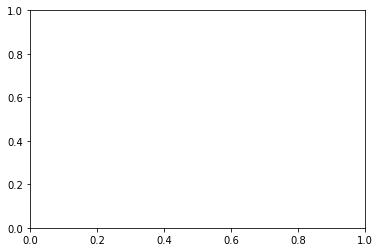

In [ ]:
plt.plot(day_new,scaler.inverse_transform(df1[1158:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))

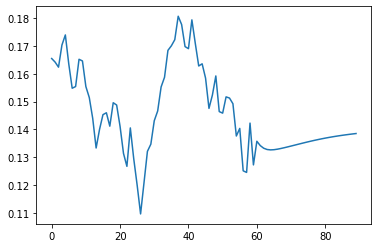

In [ ]:
df3=df1.tolist()
df3.extend(lst_output)
plt.plot(df3[1200:])

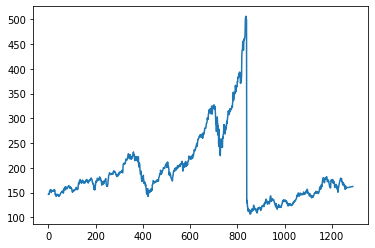

In [ ]:
df3=scaler.inverse_transform(df3).tolist()
plt.plot(df3)